In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
from scipy import optimize
from scipy import fft, ifft

In [28]:
# plot the time series of order parameter

Lx = 20 # system size = Lx x Ly
Ly = Lx
T = 0.01 # temperature
sigma = 0.01
K = 1 # strength of interaction
k_list = np.array([
    [(1,0),(0,1)],
    [(1,1),(1,-1)],
    [(2,0),(0,2)],
    [(2,1),(1,2),(2,-1),(1,-2)],
    [(2,2),(2,-2)],
    [(3,0),(0,3)],
    [(3,1),(1,3),(3,-1),(1,-3)]
])
k_list2 = (2*np.pi/Lx) * np.array([1,np.sqrt(2),2,np.sqrt(5),np.sqrt(8),3,np.sqrt(10)])

dt = 0.01 # time increment
n_steps = int(5e6) # simulation steps
t_run = n_steps * dt # simulation time

data = np.genfromtxt('Lx%d_Ly%d_T%.1e_sigma%.1e_K%.1e_t%.1e.csv'%(Lx,Ly,T,sigma,K,t_run), delimiter=",",
                     dtype=complex)

In [29]:
x_data = dt*np.arange(len(data))
y_data = np.array([
    [0,0],
    [0,0],
    [0,0],
    [0,0,0,0],
    [0,0],
    [0,0],
    [0,0,0,0]
])

index = 0
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        y_data[k][i] = np.real(ifft(np.square(np.abs(fft(np.square(np.abs(np.transpose(data)[index])))))) / len(data)
                               - np.square(np.mean(np.square(np.abs(np.transpose(data)[index])))))
        index += 1

In [30]:
def fitting_func2(x_data, a, b):
    return -a * x_data + b

popt = np.array([
    [0,0],
    [0,0],
    [0,0],
    [0,0,0,0],
    [0,0],
    [0,0],
    [0,0,0,0]
])
pcov = np.array([
    [0,0],
    [0,0],
    [0,0],
    [0,0,0,0],
    [0,0],
    [0,0],
    [0,0,0,0]
])

tcorr = np.array([250,120,60,50,31,28,25])
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        popt[k][i], pcov[k][i] = optimize.curve_fit(fitting_func2, x_data[:tcorr[k]], np.log(y_data[k][i][:tcorr[k]]))

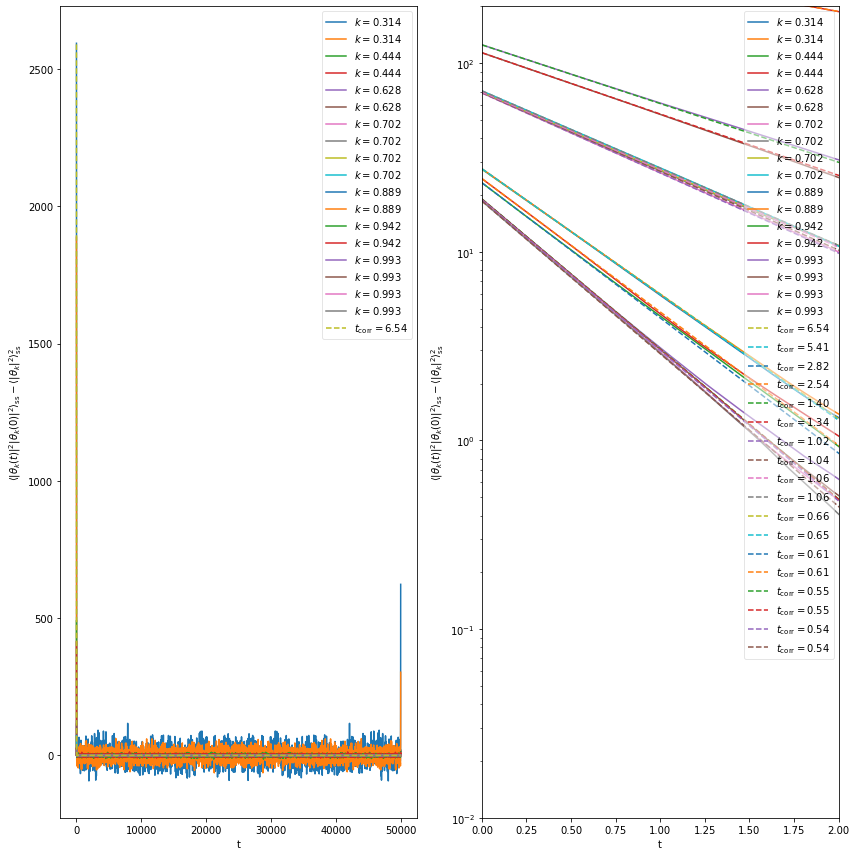

In [31]:
fig = plt.figure()
fig.set_size_inches(w=12,h=12)

plt.subplot(1,2,1)
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        plt.plot(x_data[::1000],y_data[k][i][::1000],label=r'$k = %.3f$' %k_list2[k] )
plt.plot(x_data[::1000],np.exp(-popt[0][0][0] * x_data + popt[0][0][1])[::1000],
         linestyle='dashed',label=r'$t_{\rm corr} = %.2f$' %(1/popt[0][0][0]))
plt.xlabel("t")
plt.ylabel(r"$\langle |\theta_k(t)|^2 |\theta_k(0)|^2 \rangle_{\rm ss} - \langle |\theta_k|^2 \rangle_{\rm ss}^2$")
plt.legend(loc='best', framealpha=.5)

plt.subplot(1,2,2)
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        plt.plot(x_data[:10000],y_data[k][i][:10000],label=r'$k = %.3f$' %k_list2[k] )
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        plt.plot(x_data,np.exp(-popt[k][i][0] * x_data + popt[k][i][1]),
                 linestyle='dashed',label=r'$t_{\rm corr} = %.2f$' %(1/popt[k][i][0]))
plt.xlabel("t")
plt.ylabel(r"$\langle |\theta_k(t)|^2 |\theta_k(0)|^2 \rangle_{\rm ss} - \langle |\theta_k|^2 \rangle_{\rm ss}^2$")
plt.xlim(0,2)
plt.ylim(1e-2,2e2)
plt.semilogy()
plt.legend(loc='upper right', framealpha=.5)

plt.tight_layout()
plt.show()

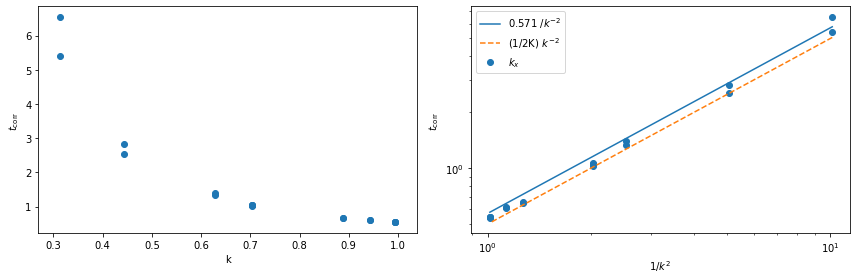

In [32]:
num_of_k = 0
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        num_of_k += 1

tcorr = np.zeros(num_of_k)
k_list3 = np.zeros(num_of_k)

index = 0
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        tcorr[index] = 1/popt[k][i][0]
        k_list3[index] = k_list2[k]
        index += 1
        
def linear_fit(x_data, a):
    return a * x_data

popt2, pcov2 = optimize.curve_fit(linear_fit, 1/(k_list3 * k_list3), tcorr)

fig = plt.figure()
fig.set_size_inches(w=12,h=4)

plt.subplot(1,2,1)
plt.scatter(k_list3,tcorr)
plt.xlabel("k")
plt.ylabel(r'$t_{\rm corr}$')

plt.subplot(1,2,2)
plt.scatter(1/(k_list3 * k_list3),tcorr,label=r'$k_x$')
plt.plot(1/(k_list3 * k_list3),linear_fit(1/(k_list3 * k_list3), popt2[0]),label=r'%.3f $/k^{-2}$' %(popt2[0]))
plt.plot(1/(k_list3 * k_list3),linear_fit(1/(k_list3 * k_list3), 1/(2*K)),
         linestyle='dashed',label=r'(1/2K) $k^{-2}$' %(popt2[0]))
plt.xlabel(r"$1/k^2$")
plt.ylabel(r'$t_{\rm corr}$')
plt.loglog()
plt.legend()

plt.tight_layout()
plt.show()

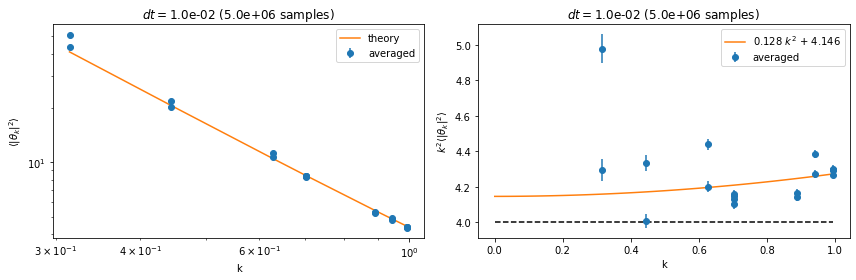

In [33]:
# determine static correlation functions from time averages and fit
def theory(x_data):
    return T*Lx*Ly/2/K/(1-np.cos(x_data))
def fitting_func(x_data, a, b):
    return a + b * x_data * x_data

corr = np.zeros(num_of_k)
y_err = np.zeros(num_of_k)

index = 0
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        corr[index] = np.average(np.square(np.abs(np.transpose(data)[index])))
        y_err[index] = np.sqrt(np.var(np.square(np.abs(np.transpose(data)[index]))) * 2 / popt[k][i][0] / (len(data) * dt))
        index += 1

fig = plt.figure()
fig.set_size_inches(w=12,h=4)

plt.subplot(1,2,1)
plt.errorbar(k_list3,corr,yerr=y_err,fmt='o',label='averaged')
plt.plot(k_list3,theory(k_list3),label='theory')
plt.xlabel("k")
plt.ylabel(r'$\langle |\theta_k|^2 \rangle$')
plt.title(r'$dt=$%.1e (%.1e samples)'% (dt, len(x_data)))
plt.legend()
plt.loglog()

plt.subplot(1,2,2)
plt.errorbar(k_list3,k_list3*k_list3*corr,yerr=k_list3*k_list3*y_err,fmt='o',label='averaged')
plt.xlabel("k")
plt.ylabel(r'$k^2 \langle |\theta_k|^2 \rangle$')
plt.title(r'$dt=$%.1e (%.1e samples)'% (dt, len(x_data)))
plt.hlines(T*Lx*Ly/K, 0, k_list2[-1], linestyles='dashed')

popt3, pcov3 = optimize.curve_fit(fitting_func, k_list3, (k_list3*k_list3*corr), sigma=(k_list3*k_list3*y_err))
x_data2 = np.linspace(0,k_list3[-1],100)
plt.plot(x_data2,fitting_func(x_data2, popt3[0], popt3[1]),label=r'%.3f $k^2$ + %.3f' %(popt3[1], popt3[0]))
plt.legend()

plt.tight_layout()
plt.show()

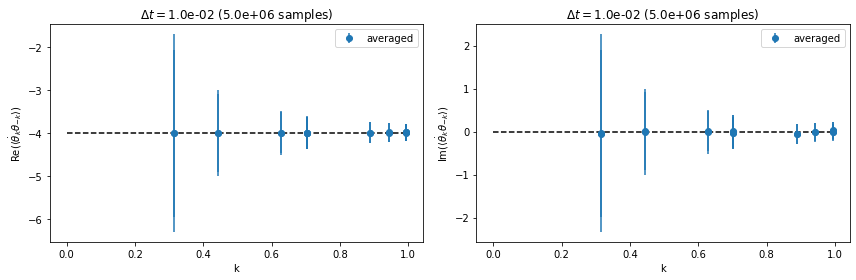

In [34]:
corr2 = np.zeros(num_of_k,dtype=complex)
z_err_re = np.zeros(num_of_k)
z_err_im = np.zeros(num_of_k)

index = 0
for k in range(len(k_list)):
    for i in range(len(k_list[k])):
        corr2[index] = np.average((np.transpose(data)[index + num_of_k] * np.conjugate(np.transpose(data)[index])))
        z_err_re[index] = np.sqrt(np.var(np.real((np.transpose(data)[index + num_of_k] * np.conjugate(np.transpose(data)[index])))) * 2 / popt[k][i][0] / (len(data) * dt))
        z_err_im[index] = np.sqrt(np.var(np.imag((np.transpose(data)[index + num_of_k] * np.conjugate(np.transpose(data)[index])))) * 2 / popt[k][i][0] / (len(data) * dt))
        index += 1


fig = plt.figure()
fig.set_size_inches(w=12,h=4)

for subplt in [1,2]:
    
    plt.subplot(1,2,subplt)

    if subplt == 1:
        plt.errorbar(k_list3,np.real(corr2),yerr=z_err_re,fmt='o',label='averaged')
    if subplt == 2:    
        plt.errorbar(k_list3,np.imag(corr2),yerr=z_err_im,fmt='o',label='averaged')
    
    if subplt == 1:
        plt.xlabel("k")
        plt.ylabel(r'Re($\langle \dot{\theta}_k \theta_{-k} \rangle$)')
        plt.hlines(-T*Lx*Ly, 0, k_list3[-1], linestyles='dashed')
        plt.title(r'$\Delta t=$%.1e (%.1e samples)'% (dt, len(x_data)))
        plt.legend()
        #plt.ylim(-5,-3)
    if subplt == 2:
        plt.xlabel("k")
        plt.ylabel(r'Im($\langle \dot{\theta}_k \theta_{-k} \rangle$)')
        plt.hlines(0, 0, k_list3[-1], linestyles='dashed')
        plt.title(r'$\Delta t=$%.1e (%.1e samples)'% (dt, len(x_data)))
        plt.legend()
        #plt.ylim(-T*Lx*Ly,T*Lx*Ly)
plt.tight_layout()
plt.show()

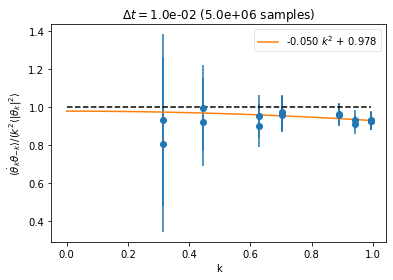

In [35]:
w_err = ( np.sqrt(np.power(z_err_re,2) / np.power(k_list3 * k_list3 * corr,2) 
                  + np.power(np.real(corr2),2) / np.power(k_list3 * k_list3 * corr,4) * np.power(k_list3 * k_list3 * y_err,2) ) )

plt.errorbar(k_list3,-np.real(corr2)/k_list3/k_list3/corr,yerr=w_err,fmt='o')
plt.xlabel("k")
plt.ylabel(r'$\langle \dot{\theta}_k \theta_{-k} \rangle/(k^2 \langle |\theta_k|^2 \rangle$')
plt.hlines(K, 0, k_list2[-1], linestyles='dashed')

popt4, pcov4 = optimize.curve_fit(fitting_func, k_list3, (-np.real(corr2)/k_list3/k_list3/corr), sigma=w_err)
plt.plot(x_data2,fitting_func(x_data2, popt4[0], popt4[1]),label=r'%.3f $k^2$ + %.3f' %(popt4[1], popt4[0]))
#plt.ylim(2,6)
plt.title(r'$\Delta t=$%.1e (%.1e samples)'% (dt, len(x_data)))
plt.legend(loc='upper right', framealpha=.5)
plt.show()

In [36]:
popt4[0]

0.9777484690573429

In [37]:
np.sqrt(pcov4[0,0])

0.018186886057919745

In [38]:
-np.real(corr2)/k_list3/k_list3/corr

array([0.80277199, 0.93112636, 0.92102664, 0.99655823, 0.90023059,
       0.95037459, 0.96143793, 0.96511391, 0.97163202, 0.95929594,
       0.96160405, 0.956755  , 0.93290607, 0.90770419, 0.92473248,
       0.92746284, 0.92640012, 0.93300194])

In [39]:
w_err

array([0.46130946, 0.45188341, 0.2300391 , 0.2266285 , 0.11310526,
       0.11367707, 0.08963292, 0.09051188, 0.0915754 , 0.09109776,
       0.0569191 , 0.0565225 , 0.05078638, 0.05041052, 0.04555066,
       0.04560151, 0.04551423, 0.04536771])

In [40]:
k_list3

array([0.31415927, 0.31415927, 0.44428829, 0.44428829, 0.62831853,
       0.62831853, 0.70248147, 0.70248147, 0.70248147, 0.70248147,
       0.88857659, 0.88857659, 0.9424778 , 0.9424778 , 0.99345883,
       0.99345883, 0.99345883, 0.99345883])